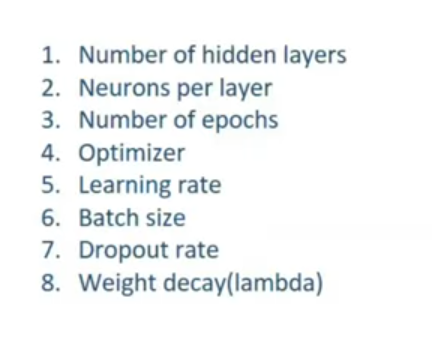

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

dataset = FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=transforms.ToTensor()
)



In [4]:
import pandas as pd
import torch

data = []
labels = []

for img, label in dataset:
    data.append(img.view(-1).numpy())   # 28×28 → 784
    labels.append(label)

df = pd.DataFrame(data)
df["label"] = labels

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [9]:
train_dataset = CustomDataset(X_train, y_train)

In [10]:
test_dataset = CustomDataset(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

1500


In [23]:
class MyNN(nn.Module):

    def __init__(self,input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

        super().__init__()
        layers = []

        for i in range(num_hidden_layers):

            layers.append(nn.Linear(input_dim,neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        layers.append(nn.Linear( neurons_per_layer, output_dim ))

        self.model = nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)

In [24]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [25]:
study = optuna.create_study(direction='maximize')

[I 2026-01-22 19:38:30,867] A new study created in memory with name: no-name-014a961f-ecaf-4fc3-a2f4-7c9fc4f773e5


In [26]:
study.optimize(objective, n_trials=10)

[I 2026-01-22 19:45:02,193] Trial 0 finished with value: 1.0 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 16, 'epochs': 30, 'learning_rate': 0.044925812870746054, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 1.8851390938734106e-05}. Best is trial 0 with value: 1.0.
[I 2026-01-22 19:46:23,116] Trial 1 finished with value: 1.0 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128, 'epochs': 10, 'learning_rate': 0.0011614969620473438, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.00024489235267373974}. Best is trial 0 with value: 1.0.
[I 2026-01-22 19:50:04,475] Trial 2 finished with value: 1.0 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 8, 'epochs': 20, 'learning_rate': 0.0011553766560249657, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.00032915866066136076}. Best is trial 0 with value: 1.0.
[I 2026-01-22 19:54:06,334] Trial 3 finish